# Demo to explore regridding masked data

Handles e.g. MCS cloud number (cn) data, where there are multiple clouds
in one mask. You have to be careful near their boundaries - naive interp
will not work here. Instead, handle each cloud as a separate mask then combine.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
%matplotlib inline

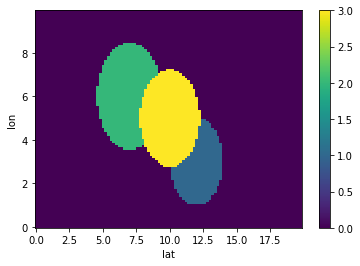

In [2]:
# Synthetic data with 3 touching clouds.
d = np.zeros((100, 100))
da = xr.DataArray(
    d,
    dims=['lon', 'lat'],
    coords={'lon': np.linspace(0, 9.9, 100) , 'lat': np.linspace(0, 19.8, 100)}
)
da.values[((da.lon - 3)**2 + (da.lat - 12)**2 < 4).values] = 1
da.values[((da.lon - 6)**2 + (da.lat - 7)**2 < 6).values] = 2
da.values[((da.lon - 5)**2 + (da.lat - 10)**2 < 5).values] = 3
da.plot();

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


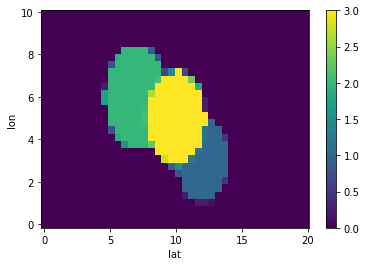

In [3]:
# Target output resolution (N.B. coarser).
ds_out = xr.Dataset(
    {"lon": (["lon"], np.linspace(0, 9.9, 30)), "lat": (["lat"], np.linspace(0, 19.8, 40))}
)

regridder = xe.Regridder(da, ds_out, "bilinear")
da_ = regridder(da)
da_.T.plot();

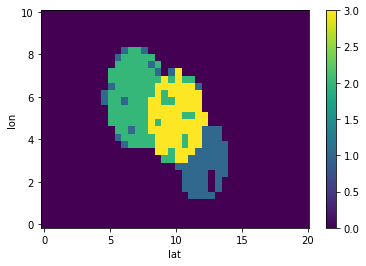

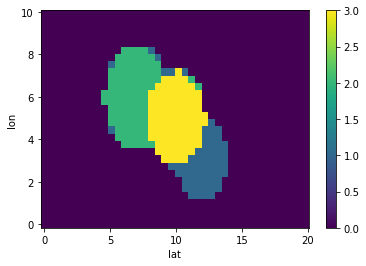

In [6]:
# Will NOT produce a good mask - due to machine round off.
# plt.figure()
da_.T.astype(int).plot()
plt.show()

# Also Will NOT produce a good mask - due to interp of some values (e.g. 3 to 1.2 rounds to 1).
da_int = da_.astype(int)
da_int.values = np.rint(da_.values)
da_int.T.astype(int).plot();

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


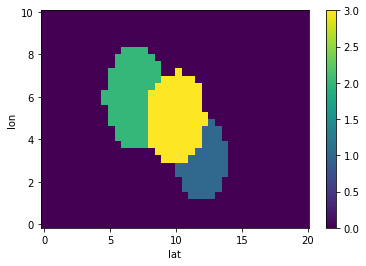

In [5]:
# N.B. if memory is an issue, you could stream and sum this.
# Take each mask separately and regrid to [0, 1] value.
mask_regridded = []
for i in range(1, 4):
    mask_regridded.append(regridder((da == i).astype(float)))

da_mask_regridded = xr.concat(mask_regridded, pd.Index(range(1, 4), name='cn'))
# Take each mask > 0.5 and multiply by its cloud number. Sum to get single mask.
da_mask = ((da_mask_regridded > 0.5).astype(int) * da_mask_regridded.cn).sum(dim='cn')

da_mask.T.plot();